In [1]:
import pandas as pd
import numpy as np
import json
import nltk
import string
import re
import sys
sys.path.append("../")
from scripts.start import iberEval, sexists
from scripts.data_utils import get_balanced_data
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import MiniBatchKMeans, KMeans, AffinityPropagation
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import homogeneity_score, v_measure_score, completeness_score, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib.cm as cm

In [2]:
tweets,categories,sources = get_balanced_data(500)

In [3]:
dfCat = pd.DataFrame(categories, columns=["category"]).astype('category')
catCodes = dfCat['category'].cat.codes
catCodes

0        2
1        2
2        2
3        2
4        2
        ..
7953    18
7954    18
7955    18
7956    18
7957    18
Length: 7958, dtype: int8

In [34]:
np.unique(categories)

array(['abusive', 'benevolent sexism', 'cyberbullying', 'derailing',
       'discredit', 'dominance', 'hateful', 'homophobic',
       'hostile sexism', 'insult', 'obscene', 'offensive', 'profane',
       'racist', 'sexual_harassment', 'spam', 'stereotype', 'threat',
       'vulgar'], dtype='<U17')

In [5]:
from collections import Counter
Counter(categories)

Counter({'cyberbullying': 355,
         'offensive': 500,
         'spam': 500,
         'abusive': 500,
         'hateful': 500,
         'profane': 500,
         'discredit': 500,
         'sexual_harassment': 410,
         'derailing': 29,
         'stereotype': 137,
         'dominance': 49,
         'obscene': 500,
         'insult': 500,
         'threat': 478,
         'racist': 500,
         'homophobic': 500,
         'benevolent sexism': 500,
         'hostile sexism': 500,
         'vulgar': 500})

In [83]:
def tokenize_and_lemmatize(text):
    text = re.sub("[@]\w+", "", text) # remove tags
    text = re.sub("<user>", "", text, flags=re.IGNORECASE) # remove <USER> tags
    text = re.sub("<url>", "", text, flags=re.IGNORECASE) # remove <URL> tags
    # remove punctuation
    table = text.maketrans({key: None for key in string.punctuation})
    text = text.translate(table)
    text = re.sub("(http)\w+", "", text) # remove links
    tokens = nltk.word_tokenize(text)
    filtered_tokens = []
    # Filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation).
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    #lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    return filtered_tokens

In [84]:
lemmatizer = WordNetLemmatizer()
englishwords = stopwords.words('english')
englishwords.extend(["u","rt","im","em","q","na","wan","’","“","”","…"])
englishwords.extend(tokenize_and_lemmatize(" ".join(englishwords)))

In [85]:
for i in range(len(tweets)):
    tweets[i] = str(tweets[i])

In [86]:
tfidf_vec = TfidfVectorizer(max_df=0.95, 
                        max_features=10000,
                        min_df=10, 
                        stop_words=englishwords, 
                        tokenizer=tokenize_and_lemmatize, 
                        ngram_range=(1,1))

In [87]:
tfidf_mat = tfidf_vec.fit_transform(tweets)
tfidf_mat.shape

(7958, 1166)

In [88]:
#clusters = MiniBatchKMeans(n_clusters=19, init_size=1024, batch_size=2048, random_state=20).fit_predict(tfidf_mat)
clusters = KMeans(n_clusters=19, random_state=20).fit_predict(tfidf_mat)

In [89]:
clustCounter = Counter(clusters)
clustCounter

Counter({11: 337,
         14: 433,
         0: 3229,
         8: 255,
         18: 442,
         4: 330,
         10: 152,
         15: 209,
         7: 316,
         13: 151,
         1: 321,
         3: 437,
         5: 68,
         6: 347,
         17: 112,
         2: 201,
         9: 307,
         16: 112,
         12: 199})

In [90]:
# Evaluating which categories make most sense by V-Score based on cluster predictions
v_measures = []
for i in range(19):
    print(np.unique(categories)[i])
    arCopy = np.array(catCodes.copy())
    arCopy[np.where(catCodes != i)] = -1
    v_measures.append(v_measure_score(arCopy, clusters))
    print(homogeneity_score(arCopy, clusters), completeness_score(arCopy, clusters), v_measure_score(arCopy, clusters))

np.unique(categories)[np.argsort(v_measures)][::-1]

abusive
0.2571241718505888 0.02587077811237443 0.04701145655175254
benevolent sexism
0.42047884571897215 0.04230685446743594 0.07687850910390108
cyberbullying
0.06651123848291182 0.005199066826915896 0.009644258858460283
derailing
0.12436565853359903 0.0012848838586410072 0.0025434896527585433
discredit
0.11683516718240766 0.011755474657025398 0.021361629854482016
dominance
0.08685595217485646 0.0013956615406287595 0.002747179500103978
hateful
0.07425787580518632 0.007471522471907318 0.013576984524307993
homophobic
0.7127101946505541 0.07170997254566151 0.13030880803098985
hostile sexism
0.12180126767269941 0.012255143291613157 0.02226960990066239
insult
0.05814001987190152 0.0058498100070849485 0.010630066393424025
obscene
0.07848676123641639 0.007897015555138635 0.014350175400458427
offensive
0.1157275291554923 0.01164402866804305 0.021159114172651605
profane
0.10721882998379957 0.010787918304277956 0.01960342091152016
racist
0.5367586947040939 0.054006455288250814 0.0981386070132679

array(['homophobic', 'racist', 'benevolent sexism', 'abusive', 'spam',
       'hostile sexism', 'discredit', 'offensive', 'profane', 'obscene',
       'sexual_harassment', 'hateful', 'vulgar', 'threat', 'insult',
       'cyberbullying', 'stereotype', 'dominance', 'derailing'],
      dtype='<U17')

In [104]:
def plot_tsne(data, labels, defLabels=None, plotlabels=None):
    max_label = max(labels)
    #max_items = np.random.choice(range(data.shape[0]), size=5000, replace=False)
    pca = PCA(n_components=2, random_state=2).fit_transform(data.todense())
    tsne = TSNE(random_state=5).fit_transform(PCA(n_components=50, random_state=2).fit_transform(data.todense()))
    
    #idx = np.random.choice(range(pca.shape[0]), size=3000, replace=False)
    label_subset = labels#[max_items]
    #label_subset = labels[idx]
    f, ax = plt.subplots(1, 1, figsize=(16, 7))
    pts2 = ax.scatter(tsne[:, 0], tsne[:, 1], c=label_subset, cmap="jet", alpha=0.5)
    ax.set_xlim(left=-92,right=110)

    if defLabels is None:
        ax.legend(*pts2.legend_elements(num=None), loc='lower right')
    else:
        ax.legend(pts2.legend_elements(num=None)[0], defLabels, loc='lower right')

    return ax, f

In [107]:
def plot_tsne_pca(data, labels,defLabels=None):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=5000, replace=False)

    pca = PCA(n_components=2).fit_transform(data.todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data.todense()))
    label_subset = labels#[max_items]

    f, ax = plt.subplots(1, 2, figsize=(26, 11))
    pts = ax[0].scatter(pca[:, 0], pca[:, 1], c=label_subset, cmap="jet")
    ax[0].set_title('PCA Cluster Plot')
    pts2 = ax[1].scatter(tsne[:, 0], tsne[:, 1], c=label_subset, cmap="jet")
    ax[1].set_title('TSNE Cluster Plot')
    if defLabels is None:
        ax[0].legend(*pts.legend_elements(num=None))
        ax[1].legend(*pts2.legend_elements(num=None))
    else:
        ax[0].legend(pts.legend_elements(num=None)[0], defLabels)
        ax[1].legend(pts2.legend_elements(num=None)[0], defLabels)

Text(0, 0, 'RACIST')

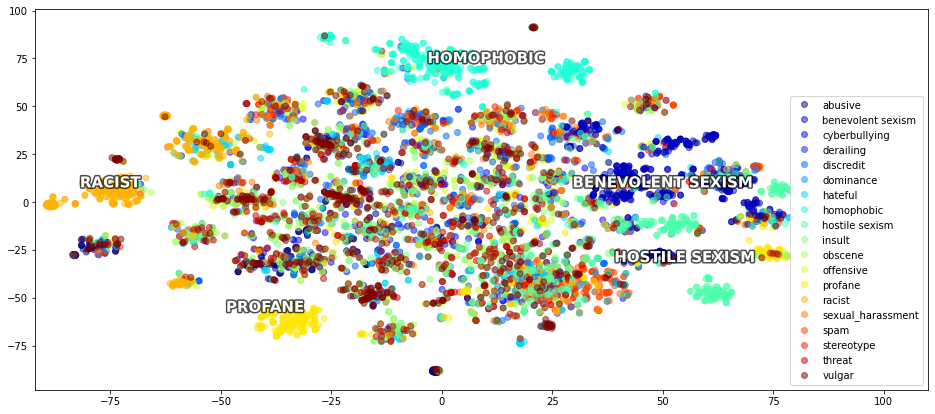

In [105]:
ax,f = plot_tsne(tfidf_mat, catCodes, np.unique(categories), np.unique(categories) )
#ax.annotate("racist".upper(), alpha=1.0, xy=(0,-75), xytext=(0, 0), textcoords='offset points', ha='center', va='center', size=15, color='white', weight='bold', fontsize=15, path_effects=[PathEffects.withStroke(linewidth=3,foreground="black", alpha=0.7)])
ax.annotate("hostile sexism".upper(), alpha=1.0, xy=(55,-29), xytext=(0, 0), textcoords='offset points', ha='center', va='center', size=15, color='white', weight='bold', fontsize=15, path_effects=[PathEffects.withStroke(linewidth=3,foreground="black", alpha=0.7)])
ax.annotate("profane".upper(), alpha=1.0, xy=(-40,-55), xytext=(0, 0), textcoords='offset points', ha='center', va='center', size=15, color='white', weight='bold', fontsize=15, path_effects=[PathEffects.withStroke(linewidth=3,foreground="black", alpha=0.7)])
#ax.annotate("vulgar".upper(), alpha=1.0, xy=(25,-70), xytext=(0, 0), textcoords='offset points', ha='center', va='center', size=15, color='white', weight='bold', fontsize=15, path_effects=[PathEffects.withStroke(linewidth=3,foreground="black", alpha=0.7)])
ax.annotate("benevolent sexism".upper(), alpha=1.0, xy=(50,10), xytext=(0, 0), textcoords='offset points', ha='center', va='center', size=15, color='white', weight='bold', fontsize=15, path_effects=[PathEffects.withStroke(linewidth=3,foreground="black", alpha=0.7)])
ax.annotate("homophobic".upper(), alpha=1.0, xy=(10,75), xytext=(0, 0), textcoords='offset points', ha='center', va='center', size=15, color='white', weight='bold', fontsize=15, path_effects=[PathEffects.withStroke(linewidth=3,foreground="black", alpha=0.7)])
ax.annotate("racist".upper(), alpha=1.0, xy=(-75,10), xytext=(0, 0), textcoords='offset points', ha='center', va='center', size=15, color='white', weight='bold', fontsize=15, path_effects=[PathEffects.withStroke(linewidth=3,foreground="black", alpha=0.7)])


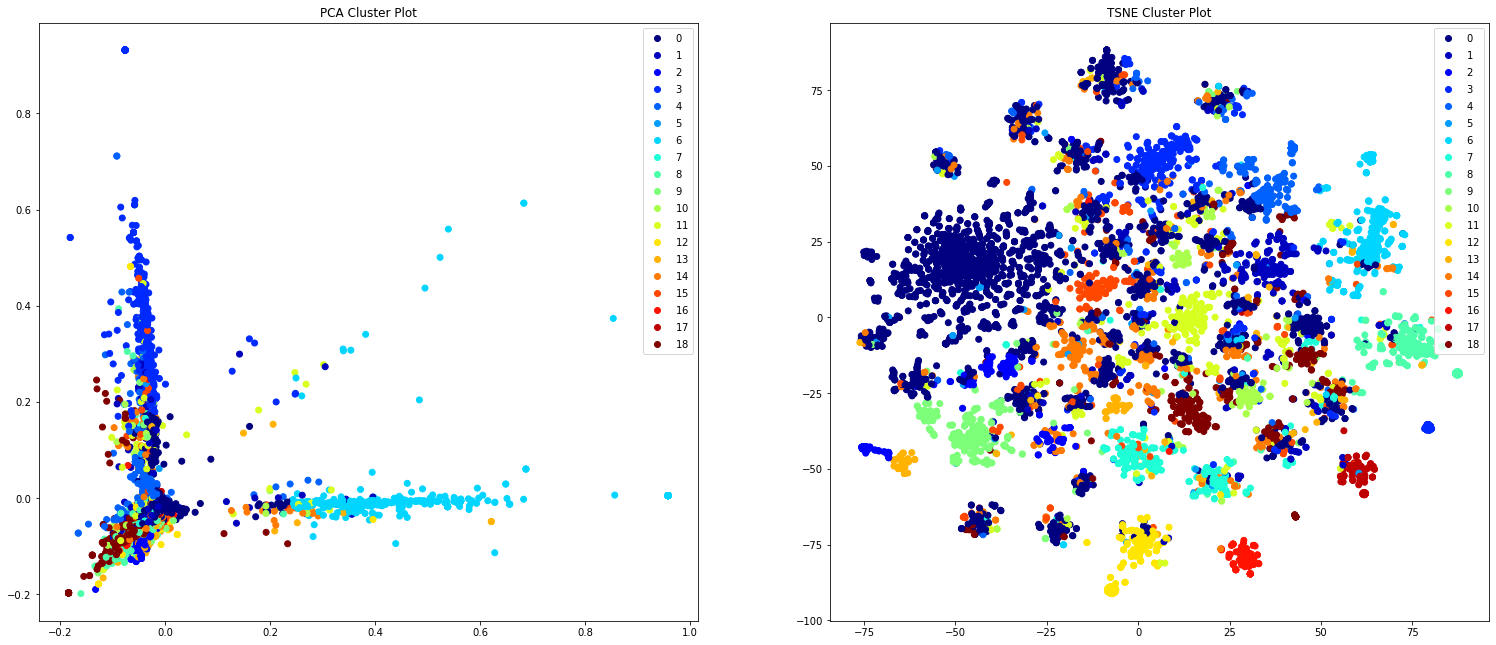

In [108]:
plot_tsne_pca(tfidf_mat, clusters)

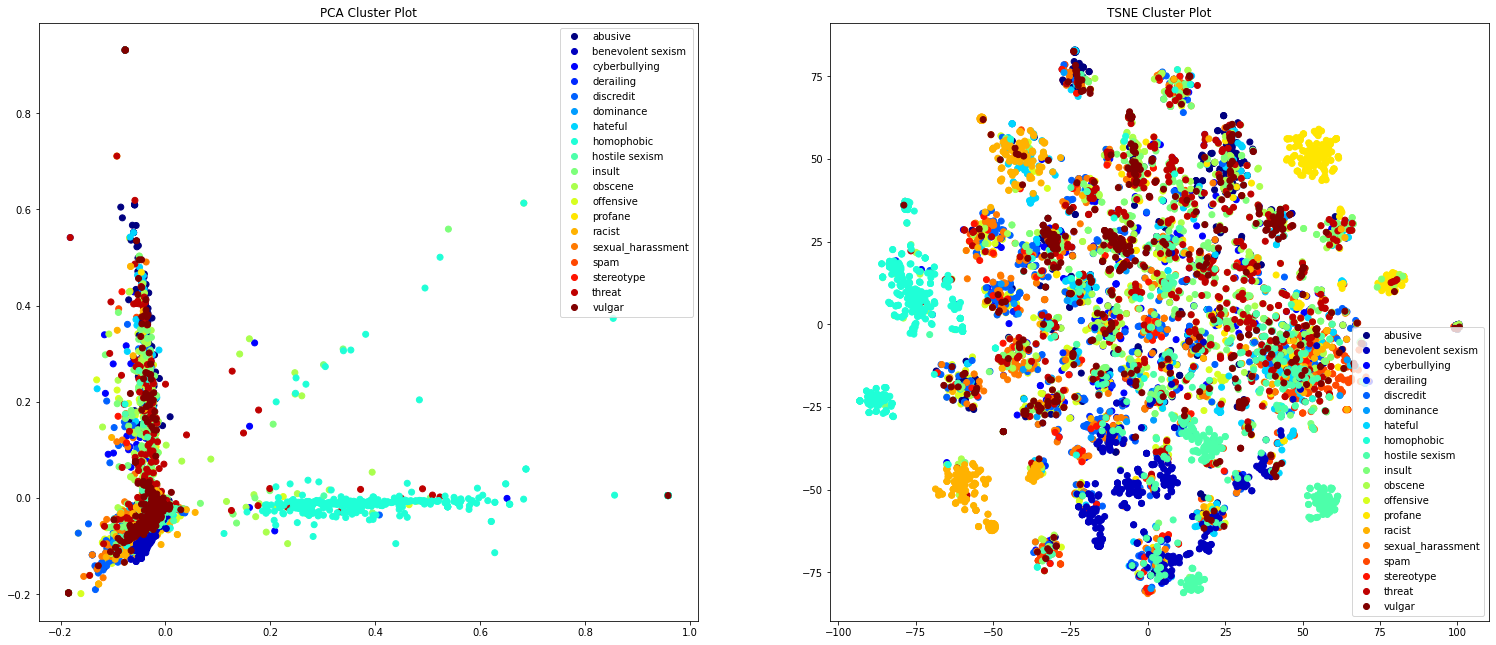

In [110]:
plot_tsne_pca(tfidf_mat, catCodes, np.unique(categories))

In [111]:
def get_top_keywords(data, clusters, labels, n_terms, categoryNames=None):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        if categoryNames is None:
            print('\nCluster {}'.format(i))
        else:
            print('\nCluster {}'.format(categoryNames[i]))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]][::-1]))
            
get_top_keywords(tfidf_mat, clusters, tfidf_vec.get_feature_names(), 15)


Cluster 0
fucktrump,ass,idiot,know,amp,one,new,dickhead,stupid,think,hell,mkr,go,stop,people

Cluster 1
shit,piece,like,bitch,fuck,fucking,know,stop,oh,going,hoe,stupid,back,ass,aint

Cluster 2
man,woman,love,like,good,lucky,last,first,luckier,without,coward,awaken,loving,intention,biggest

Cluster 3
fucking,hate,cant,know,go,people,racist,cunt,stupid,bush,george,fucktrump,bitch,calling,really

Cluster 4
fuck,go,cunt,bitch,stupid,fucking,shut,fucktrump,give,think,ass,say,asshole,still,oh

Cluster 5
around,like,make,people,yall,wikipedia,fucking,time,get,bitches,stop,know,would,played,bitch

Cluster 6
faggot,see,look,called,use,straight,fucking,fuck,shut,gay,sissy,like,say,men,ass

Cluster 7
girl,bitches,bitch,tall,dick,got,one,boy,know,hoe,rape,bad,ass,hate,good

Cluster 8
nigga,like,got,bitch,ass,fuck,hate,mad,said,bout,yo,damn,aint,pussy,money

Cluster 9
women,men,sexist,womensday,rape,adaywithoutwomen,amp,like,without,notsexist,world,internationalwomensday,man,happy,many

Cluster 1

In [66]:
get_top_keywords(tfidf_mat, catCodes, tfidf_vec.get_feature_names(), 10, np.unique(categories))


Cluster abusive
fucking,fucked,bad,ass,like,cant,idiot,hate,bitch,go

Cluster benevolent sexism
man,woman,love,womensday,like,women,girl,good,without,adaywithoutwomen

Cluster cyberbullying
bra,get,know,bitch,fake,like,fuck,shit,lol,stop

Cluster derailing
women,rape,woman,men,lol,bitch,whore,dick,dress,every

Cluster discredit
bitch,stupid,whore,hoe,girl,slut,women,like,pussy,ass

Cluster dominance
bitch,women,like,whore,yesallmen,men,girl,cock,shut,dick

Cluster hateful
niggas,hate,nigga,fucking,idiot,like,mad,people,amp,idiots

Cluster homophobic
faggot,dyke,look,see,like,called,gay,straight,sissy,big

Cluster hostile sexism
sexist,mkr,women,kat,notsexist,girls,female,call,men,think

Cluster insult
fuck,fucking,go,wikipedia,shit,page,like,get,suck,ass

Cluster obscene
fuck,fucking,go,suck,get,shit,page,wikipedia,asshole,ass

Cluster offensive
bitch,bitches,hoes,pussy,hoe,like,fuck,aint,got,shit

Cluster profane
fucktrump,dickhead,douchebag,trump,fuck,trumpisatraitor,resist,fucking,

Some clusters are clearly distinct and match some categories: eg. cluster 1 and benevolent sexism, cluster 4 and homophobic, cluster 13 and profane

## Grouping documents by category & using TFIDF and word2vec embeddings

In [67]:
uniquecategories = np.unique(categories)
tweetsNP = np.array(tweets)
tweetsByCategory = []
for i in range(len(uniquecategories)):
    indices = np.where(np.array(categories) == uniquecategories[i])
    tweetsByCategory.append(" ".join(list(tweetsNP[indices])))
uniquecategories = np.array(["benevolent" if c == "benevolent sexism" else "hostile" if c == 'hostile sexism' else "harassment" if c == 'sexual_harassment' else c for c in uniquecategories])

In [68]:
tfidf_vec3 = TfidfVectorizer(max_df=1.0,
                        max_features=10000,
                        min_df=3, 
                        stop_words=englishwords, 
                        tokenizer=tokenize_and_lemmatize, 
                        ngram_range=(1,1))

In [69]:
tfidf_mat3 = tfidf_vec3.fit_transform(tweetsByCategory)
tfidf_mat3.shape

(19, 3250)

In [70]:
documentVectors = tfidf_mat3.todense()
#documentVectors = documentVectors / np.linalg.norm(documentVectors, axis=1).flatten()

In [71]:
similarities = documentVectors.dot(documentVectors.T)

In [72]:
ap = AffinityPropagation(affinity='precomputed', damping=0.51).fit(similarities)

C:\Users\Beni\anaconda3\envs\nlp\lib\site-packages\sklearn\cluster\_affinity_propagation.py:146: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(("'random_state' has been introduced in 0.23. "


In [73]:
ixs = np.argsort(ap.labels_)
ixs

array([ 1, 16,  3,  4,  5, 11, 14,  7,  8,  9, 17, 10, 13, 15,  0,  6,  2,
       12, 18], dtype=int64)

In [74]:
simsorted = similarities[ixs,:][:,ixs]
uniquecatssorted = uniquecategories[ixs]

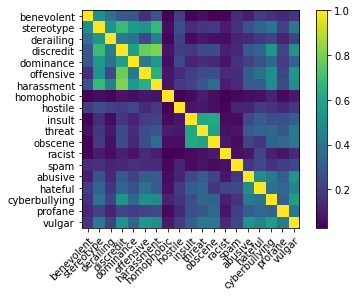

In [75]:
fig, ax = plt.subplots()
heatmap = plt.imshow(simsorted)
ax.set_yticks(np.arange(len(uniquecatssorted)))
ax.set_yticklabels(uniquecatssorted)
ax.set_xticks(np.arange(len(uniquecatssorted)))
ax.set_xticklabels(uniquecatssorted)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.colorbar(heatmap)
plt.show()

### Word2vec average document representations

In [76]:
import gensim.downloader as api

In [77]:
word2vec = api.load('word2vec-google-news-300')

In [78]:
documentVectors = np.zeros((300,19))
npFeatures = np.array(tfidf_vec3.get_feature_names())
for i in range(19):
    row = np.array(tfidf_mat3.getrow(i).todense()).flatten()
    indices = row.argsort()[::-1][:30]
    print(uniquecategories[i], npFeatures[indices])
    for ix in indices:
        if npFeatures[ix] in word2vec:
            documentVectors[:,i] += word2vec[npFeatures[ix]] * row[ix]

abusive ['fucking' 'fucked' 'ass' 'like' 'bad' 'bitch' 'fuck' 'idiot' 'shit'
 'idiots' 'want' 'get' 'know' 'hate' 'cant' 'people' 'go' 'bitches' 'yall'
 'ugly' 'say' 'even' 'stop' 'thats' 'george' 'stupid' 'need' 'damn' 'bush'
 'got']
benevolent ['woman' 'man' 'love' 'like' 'women' 'girl' 'good' 'amp' 'lucky' 'without'
 'happy' 'intention' 'loving' 'every' 'first' 'last' 'strong' 'day'
 'coward' 'world' 'men' 'think' 'beautiful' 'act' 'girls' 'wife' 'life'
 'would' 'biggest' 'mother']
cyberbullying ['fake' 'bra' 'bitch' 'r' 'like' 'fucking' 'get' 'fuck' 'shit' 'know'
 'ass' 'stop' 'ugly' 'go' 'life' 'ur' 'haha' 'okay' 'say' 'lol' 'hoe'
 'stupid' 'face' 'one' 'suck' 'would' 'anonymous' 'people' 'pretty'
 'think']
derailing ['women' 'woman' 'rape' 'bitch' 'forward' 'men' 'dumbass' 'sexism'
 'assault' 'dick' 'come' 'yesallmen' 'birth' 'whore' 'like' 'pregnant'
 'sexual' 'lol' 'dress' 'control' 'hole' 'girl' 'every' 'get' 'want'
 'understand' 'sign' 'asked' 'cuz' 'free']
discredit ['bitch'

In [79]:
documentVectors = documentVectors / np.linalg.norm(documentVectors, axis=0)

In [80]:
similarities = documentVectors.T.dot(documentVectors)

In [81]:
ap = AffinityPropagation(affinity='precomputed', damping=0.51).fit(similarities)
ixs = np.argsort(ap.labels_)
simsorted = similarities[ixs,:][:,ixs]
uniquecatssorted = uniquecategories[ixs]

C:\Users\Beni\anaconda3\envs\nlp\lib\site-packages\sklearn\cluster\_affinity_propagation.py:146: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(("'random_state' has been introduced in 0.23. "


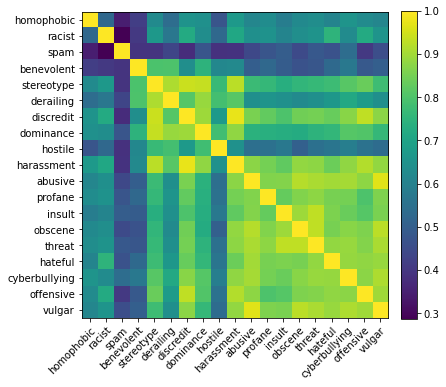

In [109]:
fig, ax = plt.subplots()
heatmap = plt.imshow(simsorted)
fig.set_size_inches(6, 6)
ax.set_yticks(np.arange(len(uniquecatssorted)))
ax.set_yticklabels(uniquecatssorted)
ax.set_xticks(np.arange(len(uniquecatssorted)))
ax.set_xticklabels(uniquecatssorted)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.colorbar(heatmap,fraction=0.046, pad=0.04)
plt.show()

## Word2vec averaging without grouping

In [9]:
import gensim.downloader as api
word2vec = api.load('word2vec-google-news-300')

In [112]:
words = tfidf_vec.get_feature_names()
notInVocab = [w not in word2vec for w in words]

In [113]:
englishwords.extend(list(np.array(words)[notInVocab]))

In [114]:
tfidf_vec2 = TfidfVectorizer(max_df=0.9, 
                        max_features=10000,
                        min_df=10, 
                        stop_words=englishwords, 
                        tokenizer=tokenize_and_lemmatize,
                        norm='l1',
                        use_idf=False,
                        ngram_range=(1,1))

In [115]:
tfidf_mat = tfidf_vec2.fit_transform(tweets)
tfidf_mat.shape

(7958, 1137)

In [116]:
allwords = tfidf_vec2.get_feature_names()
wordvectors = np.zeros((len(allwords),300))
for i in range(len(allwords)):
    wordvectors[i,:] = word2vec[allwords[i]]

In [117]:
docVectors = np.dot(tfidf_mat.todense(),wordvectors)

In [118]:
docVectors.shape

(7958, 300)

In [119]:
categoryVectors = np.zeros((19,300))
categoryVectors.shape

(19, 300)

In [120]:
for i in range(19):
    categoryVectors[i,:] = np.array(np.mean(docVectors[np.where(catCodes == i)[0],:],axis=0)).flatten()

In [121]:
documentVectors = (np.array(categoryVectors).T / np.linalg.norm(categoryVectors, axis=1)).T

In [122]:
similarities = documentVectors.dot(documentVectors.T)

In [123]:
ap = AffinityPropagation(affinity='precomputed', damping=0.51).fit(similarities)
ixs = np.argsort(ap.labels_)
simsorted = similarities[ixs,:][:,ixs]
uniquecategories = np.unique(categories)
uniquecategories = np.array(["benevolent" if c == "benevolent sexism" else "hostile" if c == 'hostile sexism' else "harassment" if c == 'sexual_harassment' else c for c in uniquecategories])
uniquecatssorted = uniquecategories[ixs]

C:\Users\Beni\anaconda3\envs\nlp\lib\site-packages\sklearn\cluster\_affinity_propagation.py:146: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(("'random_state' has been introduced in 0.23. "


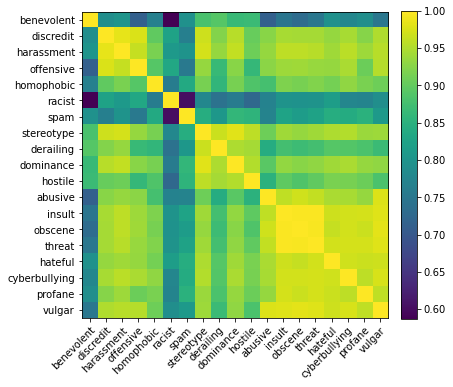

In [124]:
fig, ax = plt.subplots()
heatmap = plt.imshow(simsorted)
fig.set_size_inches(6, 6)
ax.set_yticks(np.arange(len(uniquecatssorted)))
ax.set_yticklabels(uniquecatssorted)
ax.set_xticks(np.arange(len(uniquecatssorted)))
ax.set_xticklabels(uniquecatssorted)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.colorbar(heatmap,fraction=0.046, pad=0.04)
plt.show()

In [125]:
ap.labels_

array([6, 0, 6, 5, 1, 5, 6, 2, 5, 6, 6, 1, 6, 3, 1, 4, 5, 6, 6],
      dtype=int64)